# Explore $a$ in Loisel 2023 outputs

In [1]:
# imports
import os
import numpy as np

import seaborn as sns
from sklearn import decomposition

from matplotlib import pyplot as plt

import xarray

# Info

## X=1,2,4:  Nothing, Raman, Raman+Flourescence

## YY = Sun zenith angle

## 3320 different IOP combinations

# Load 

In [2]:
l23_path = '/home/xavier/Projects/Oceanography/Color/data/Loisel2023'

## Variables

In [3]:
variable_file = os.path.join(l23_path, 'Hydrolight400.nc')

In [4]:
var = xarray.load_dataset(variable_file)
var

<xarray.Dataset>
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 0.7753 0.7314 0.7207 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 0.04075 0.03903 ... 0.06316 0.0624
    a        (IOP_Scenario, Lambda) float32 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 0.02386 0.02245 ... 0.0005 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 0.04521 0.04454 ... 0.1013 0.1008
    bd       (IOP_Scenario, Lambda) float32 0.03323 0.03239 ... 0.03532 0.03513
    bb       (IOP_Scenario, Lambda) float32 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 0.0005982 0.000583 ... 0.0006324

In [5]:
var.a.shape

(3320, 81)

In [6]:
D = var.a.shape[1]

# Plot one

<Axes: xlabel='Lambda'>

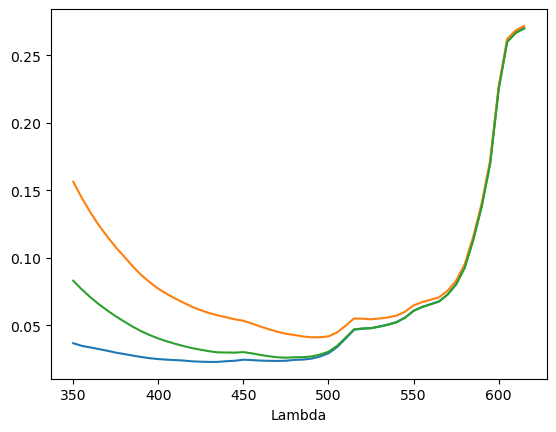

In [7]:
waves = var.Lambda.data < 620.
plt.clf()
ax = plt.gca()
sns.lineplot(x=var.Lambda[waves], y=var.a.data[100,waves], ax=ax)
sns.lineplot(x=var.Lambda[waves], y=var.a.data[1000,waves], ax=ax)
sns.lineplot(x=var.Lambda[waves], y=var.a.data[2000,waves], ax=ax)

## PCA me

## Mean $a$

In [8]:
mean_spec = np.mean(var.a.data, axis=0)

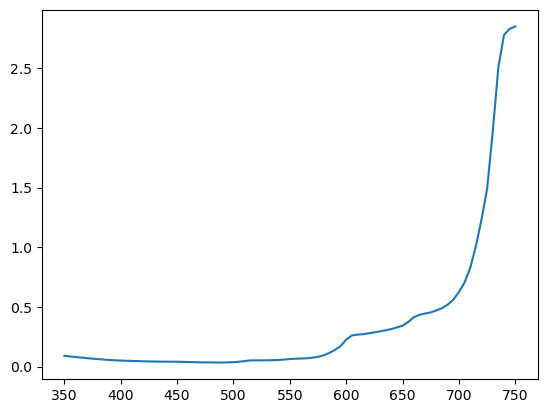

In [9]:
plt.clf()
ax = plt.gca()
ax.plot(var.Lambda, mean_spec)
#
plt.show()

## Full fits

In [10]:
pca_fit_cut = decomposition.PCA(n_components=np.sum(waves)).fit(var.a.data[:,waves])

In [13]:
pca_fit = decomposition.PCA(n_components=D).fit(var.a.data)

### Variance

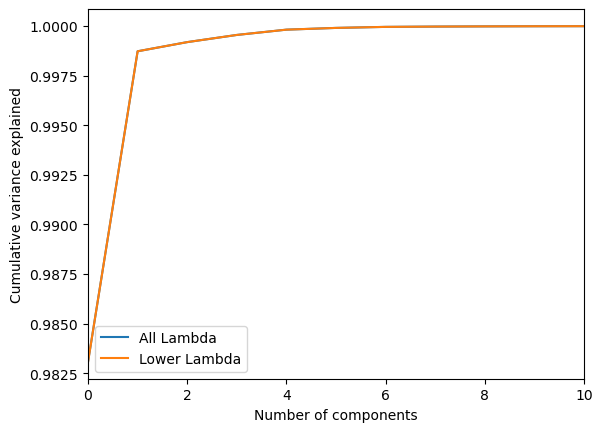

In [14]:
plt.clf()
ax = plt.gca()
ax.plot(np.cumsum(pca_fit.explained_variance_ratio_), label='All Lambda')
ax.plot(np.cumsum(pca_fit_cut.explained_variance_ratio_), label='Lower Lambda')
# Label
ax.set_ylabel('Cumulative variance explained')
ax.set_xlabel('Number of components')
#
ax.set_xlim(0,10.)
#
ax.legend()
#
plt.show()

# Reduced fits

In [15]:
pca_fit3 = decomposition.PCA(n_components=3).fit(var.a.data)

In [16]:
pca_fit3.explained_variance_ratio_

array([9.8307675e-01, 1.5646266e-02, 4.6115200e-04], dtype=float32)

## Eigenvectors

In [17]:
M3 = pca_fit3.components_

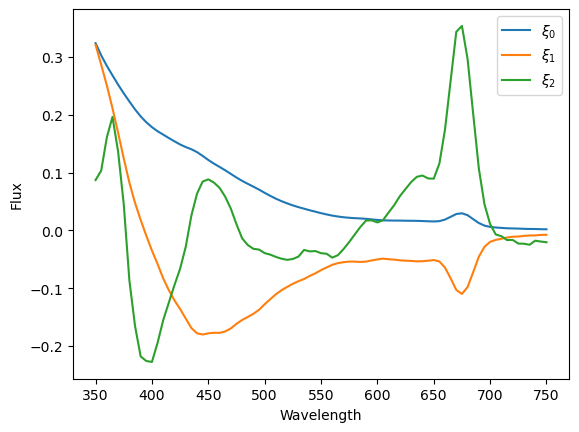

In [18]:
plt.clf()
ax = plt.gca()
ax.plot(var.Lambda,M3[0], label=r'$\xi_0$')
ax.plot(var.Lambda,M3[1], label=r'$\xi_1$')
ax.plot(var.Lambda,M3[2], label=r'$\xi_2$')
#
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
#
ax.legend()
#
plt.show()

## Explore the coefficients

In [19]:
pca_projected3 = pca_fit3.fit_transform(var.a.data)

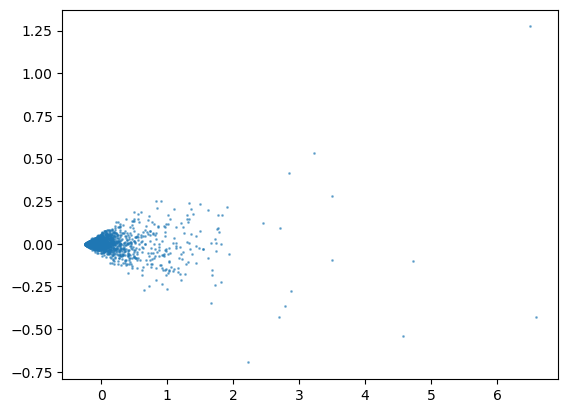

In [22]:
plt.clf()
ax=plt.gca()
ax.scatter(pca_projected3[:,0], pca_projected3[:,1], alpha=0.5, s=1)
#
plt.show()

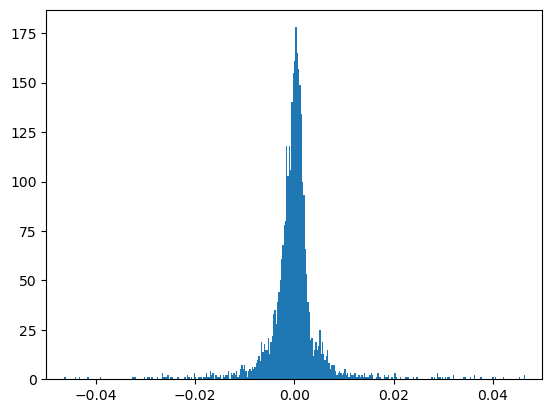

In [26]:
plt.clf()
ax= plt.gca()
ax.hist(pca_projected3[:,2], 1000)
ax.set_xlim(-0.05, 0.05)
plt.show()

## Reconstruct

In [60]:
Y3 = pca_fit3.transform(var.a.data)

In [61]:
a_recon3 = np.dot(Y3, M3) + mean_spec

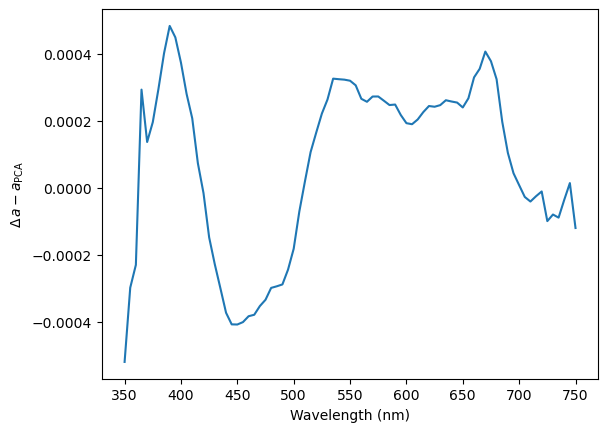

In [63]:
idx = 0
plt.clf()
ax = plt.gca()
#
ax.plot(var.Lambda, var.a.data[idx] - a_recon3[idx])#, label='Real')
#ax.plot(var.Lambda, a_recon3[idx], label='Model')
#
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$\Delta \, a - a_{\rm PCA}$')
plt.show()

## RMS

In [66]:
rms = np.sqrt(np.mean((var.a.data - a_recon3)**2))
rms

0.0012414708

In [69]:
all_rms = np.sqrt(np.mean((var.a.data - a_recon3)**2, axis=1))
np.max(all_rms)

0.012801219

In [70]:
imax = np.argmax(all_rms)

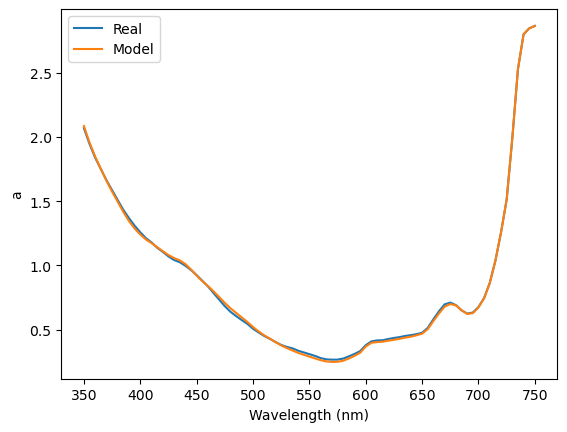

In [73]:
idx = imax
plt.clf()
ax = plt.gca()
#
ax.plot(var.Lambda, var.a.data[idx], label='Real')
ax.plot(var.Lambda, a_recon3[idx], label='Model')
#
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('a')
#
ax.legend()
plt.show()

In [74]:
imax

2949

## Properties of the "outlier"

In [79]:
for property in ['a', 'anw', 'aph', 'ag', 'b', 'bb', 'bbph', 'bbd']:
    print(f'{property} = {var[property].data[imax,0]}')

a = 2.0689001083374023
anw = 2.061800003051758
aph = 0.36484000086784363
ag = 1.2704999446868896
b = 0.8513699769973755
bb = 0.021028999239206314
bbph = 0.0
bbd = 0.015111999586224556


In [80]:
np.max(var.anw[:,0])

<xarray.DataArray 'anw' ()>
array(2.6114, dtype=float32)
Coordinates:
    Lambda   float32 350.0

----

# But what about $b$?

In [81]:
var.b[0]

<xarray.DataArray 'b' (Lambda: 81)>
array([0.090283, 0.088042, 0.085944, 0.083409, 0.081526, 0.079572,
       0.077426, 0.075615, 0.073875, 0.072172, 0.070504, 0.068879,
       0.067288, 0.065763, 0.064296, 0.062916, 0.061532, 0.060228,
       0.059085, 0.058053, 0.057073, 0.056084, 0.055125, 0.05422 ,
       0.053359, 0.05252 , 0.051689, 0.050909, 0.050205, 0.049589,
       0.04901 , 0.048449, 0.047883, 0.047285, 0.046688, 0.046079,
       0.045489, 0.044897, 0.044304, 0.043727, 0.043148, 0.042586,
       0.04202 , 0.041464, 0.040915, 0.040358, 0.039823, 0.039294,
       0.03877 , 0.03828 , 0.037805, 0.037333, 0.036864, 0.03638 ,
       0.035926, 0.035497, 0.035052, 0.03462 , 0.034208, 0.033785,
       0.033377, 0.032954, 0.03246 , 0.031927, 0.031378, 0.030968,
       0.030742, 0.030698, 0.030623, 0.030447, 0.030178, 0.029897,
       0.029603, 0.029307, 0.02899 , 0.028704, 0.028431, 0.028154,
       0.027875, 0.027598, 0.027321], dtype=float32)
Coordinates:
  * Lambda   (Lambda) float32 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0